In [1]:
# imports and function definitions
import glob, os, re
from pathlib import Path

from tqdm import tqdm
import json
from netCDF4 import Dataset

import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


Load Data/params

In [2]:
# load the dictionary from the JSON file
path = 14
frame = 5
cwd = os.getcwd()
tifs_path = os.path.join(cwd, 'tifs_single_glacier') #type Path

json_path = os.path.join(cwd, "dict.json")


with open(json_path, "r") as file:
    loaded_sar_data = json.load(file)

path = int(next(iter(loaded_sar_data['1']['path_frame_dict'])))
frame = int(loaded_sar_data['1']['path_frame_dict'][str(path)][0])
#print(path, frame)
out_nc_fn = loaded_sar_data['1']['cube_fn']
filename = os.path.basename(out_nc_fn)   

rgi_id = filename.split("_")[1].split(".")[0]
glac_input = int(rgi_id[-5:])
print("Rgi id and input number:", rgi_id, glac_input)

# all processed path/frame datacubes
loaded_sar_data


Rgi id and input number: 01-05761 5761


{'1': {'location_str': 'Kennicott',
  'scene_name': 'Kennicott',
  'cube_fn': 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\merged_01-05761.nc',
  'epsg_no': '32607',
  'path_frame_dict': {'14': ['5']},
  'Direction': 'Ascending',
  'frame_cut': 0,
  'pol_str': 'VH'}}

In [3]:
#get glaciers
# define glacier outline
res = 100
RGI_shapefile_path = "C:/Users/jaden/Downloads/Research/Glaciers/RGI2000-v7.0-G-01_alaska"
band = 'VH'
xres,yres = (res,res)   # output (datacube) resolution in projection meters

# RGI data
rgi_fp = "C:/Users/jaden/Downloads/Research/Glaciers/" # change folderpath
rgi_cols_drop = ['glims_id', 'anlys_id', 'subm_id']



Define functions/classes

In [4]:
#Percentile function

# faster alternative to np.nanpercentile -- from https://krstn.eu/np.nanpercentile()-there-has-to-be-a-faster-way/
def nan_percentile(arr, q, axis=0):
    arr = np.asarray(arr)
    # Move the desired axis to the front
    arr = np.moveaxis(arr, axis, 0)

    # valid (non-NaN) observations along the first axis
    valid_obs = np.sum(np.isfinite(arr), axis=0)
    max_val = np.nanmax(arr)
    arr = arr.copy()  # avoid modifying original input
    arr[np.isnan(arr)] = max_val
    arr = np.sort(arr, axis=0)

    # Handle list or single q
    qs = [q] if np.isscalar(q) else q
    result = []

    for quant in qs:
        k_arr = (valid_obs - 1) * (quant / 100.0)
        f_arr = np.floor(k_arr).astype(np.int32)
        c_arr = np.ceil(k_arr).astype(np.int32)
        fc_equal_k_mask = f_arr == c_arr

        floor_val = _zvalue_from_index(arr, f_arr) * (c_arr - k_arr)
        ceil_val  = _zvalue_from_index(arr, c_arr) * (k_arr - f_arr)

        quant_arr = floor_val + ceil_val
        quant_arr[fc_equal_k_mask] = _zvalue_from_index(arr, k_arr.astype(np.int32))[fc_equal_k_mask]

        result.append(quant_arr)

    if np.isscalar(q):
        return result[0]
    return np.stack(result, axis=0)

def _zvalue_from_index(arr, ind):
    """
    Extracts values along the first axis of a 3D array given 2D indices.
    """
    # arr shape = (depth, y, x)
    d, nC, nR = arr.shape
    # Compute linear indices
    idx = nC*nR*ind + nR*np.arange(nC)[:, None] + np.arange(nR)
    return np.take(arr, idx)
    

In [5]:
#DescStr

class DescStr:
    def __init__(self):
        self._desc = ''
    def write(self, instr):
        self._desc += re.sub('\n|\x1b.*|\r', '', instr)
    def read(self):
        ret = self._desc
        self._desc = ''
        return ret
    def flush(self):
        pass

In [6]:
#Select glaciers func
def selectglaciersrgitable(glac_no=None, rgi_regionsO1=None, rgi_regionsO2='all', rgi_glac_number='all',
                           rgi_fp=rgi_fp, rgi_cols_drop=rgi_cols_drop,
                           include_landterm=True, include_laketerm=True, include_tidewater=True,
                           glac_no_skip=None, min_glac_area_km2=0):
    """
    Select all glaciers to be used in the model run according to the regions and glacier numbers defined by the RGI
    glacier inventory. This function returns the rgi table associated with all of these glaciers.

    glac_no : list of strings
        list of strings of RGI glacier numbers (e.g., ['1.00001', '13.00001'])
    rgi_regionsO1 : list of integers
        list of integers of RGI order 1 regions (e.g., [1, 13])
    rgi_regionsO2 : list of integers or 'all'
        list of integers of RGI order 2 regions or simply 'all' for all the order 2 regions
    rgi_glac_number : list of strings
        list of RGI glacier numbers without the region (e.g., ['00001', '00002'])

    Output: Pandas DataFrame of the glacier statistics for each glacier in the model run
    (rows = GlacNo, columns = glacier statistics)
    """
    if glac_no is not None:
        glac_no_byregion = {}
        rgi_regionsO1 = [int(i.split('.')[0]) for i in glac_no]
        rgi_regionsO1 = list(set(rgi_regionsO1))
        for region in rgi_regionsO1:
            glac_no_byregion[region] = []
        for i in glac_no:
            region = i.split('.')[0]
            glac_no_only = i.split('.')[1]
            glac_no_byregion[int(region)].append(glac_no_only)

        for region in rgi_regionsO1:
            glac_no_byregion[region] = sorted(glac_no_byregion[region])

    # Create an empty dataframe
    rgi_regionsO1 = sorted(rgi_regionsO1)
    glacier_table = pd.DataFrame()
    for region in rgi_regionsO1:

        if glac_no is not None:
            rgi_glac_number = glac_no_byregion[region]

        for i in os.listdir(rgi_fp):
            if str(region).zfill(2) in i:
                rgi_fp_reg = rgi_fp + i + '/'
        print(rgi_fp_reg)
        for i in os.listdir(rgi_fp_reg):
            if i.endswith('attributes.csv'):
                rgi_fn = i
                
        try:
            csv_regionO1 = pd.read_csv(rgi_fp_reg + rgi_fn)
        except:
            csv_regionO1 = pd.read_csv(rgi_fp_reg + rgi_fn, encoding='latin1')

        # Populate glacer_table with the glaciers of interest
        if rgi_regionsO2 == 'all' and rgi_glac_number == 'all':
            print("All glaciers within region(s) %s are included in this model run." % (region))
            if glacier_table.empty:
                glacier_table = csv_regionO1
            else:
                glacier_table = pd.concat([glacier_table, csv_regionO1], axis=0)
        elif rgi_regionsO2 != 'all' and rgi_glac_number == 'all':
            print("All glaciers within subregion(s) %s in region %s are included in this model run." %
                  (rgi_regionsO2, region))
            for regionO2 in rgi_regionsO2:
                regionO2_str = str(region).zfill(2) + '-' + str(regionO2).zfill(2)
                if glacier_table.empty:
                    glacier_table = csv_regionO1.loc[csv_regionO1['o2region'] == regionO2_str]
                else:
                    glacier_table = (pd.concat([glacier_table, csv_regionO1.loc[csv_regionO1['o2region'] ==
                                                                                regionO2_str]], axis=0))
        else:
            if len(rgi_glac_number) < 20:
                print("%s glaciers in region %s are included: %s" % (len(rgi_glac_number), region, rgi_glac_number))
            else:
                print("%s glaciers in region %s are included" % (len(rgi_glac_number), region))
                
            rgiid_subset = ['RGI2000-v7.0-G-' + str(region).zfill(2) + '-' + x.zfill(5) for x in rgi_glac_number]
            rgiid_all = list(csv_regionO1.rgi_id.values)
            rgi_idx = [rgiid_all.index(x) for x in rgiid_subset if x in rgiid_all]
            if glacier_table.empty:
                glacier_table = csv_regionO1.loc[rgi_idx]
            else:
                glacier_table = (pd.concat([glacier_table, csv_regionO1.loc[rgi_idx]],
                                           axis=0))

    glacier_table = glacier_table.copy()
    # reset the index so that it is in sequential order (0, 1, 2, etc.)
    glacier_table.reset_index(inplace=True)

    # drop connectivity 2 for Greenland and Antarctica
    glacier_table = glacier_table.loc[glacier_table['conn_lvl'].isin([0,1])]
    glacier_table.reset_index(drop=True, inplace=True)

    # add a simple glacier number column
    glacier_table['glacno'] = [int(x.split('-')[-1]) for x in glacier_table.rgi_id.values]

    # drop columns of data that is not being used
    glacier_table.drop(rgi_cols_drop, axis=1, inplace=True)

    # Longitude between 0-360deg (no negative)
    glacier_table['cenlon_360'] = glacier_table['cenlon']
    glacier_table.loc[glacier_table['cenlon'] < 0, 'cenlon_360'] = (
            360 + glacier_table.loc[glacier_table['cenlon'] < 0, 'cenlon_360'])
    # Subset glaciers based on their terminus type
    termtype_values = []
    if include_landterm:
        termtype_values.append(0)
        # assume dry calving, regenerated, and not assigned are land-terminating
        termtype_values.append(3)
        termtype_values.append(4)
        termtype_values.append(9)
    if include_tidewater:
        termtype_values.append(1)
        # assume shelf-terminating glaciers are tidewater
        termtype_values.append(5)
    if include_laketerm:
        termtype_values.append(2)
    glacier_table = glacier_table.loc[glacier_table['term_type'].isin(termtype_values)]
    glacier_table.reset_index(inplace=True, drop=True)

    # Remove glaciers below threshold
    glacier_table = glacier_table.loc[glacier_table['area_km2'] > min_glac_area_km2,:]
    glacier_table.reset_index(inplace=True, drop=True)

    # Remove glaciers that are meant to be skipped
    if glac_no_skip is not None:
        glac_no_all = list(glacier_table['glacno'])
        glac_no_unique = [x for x in glac_no_all if x not in glac_no_skip]
        unique_idx = [glac_no_all.index(x) for x in glac_no_unique]
        glacier_table = glacier_table.loc[unique_idx,:]
        glacier_table.reset_index(inplace=True, drop=True)

    print("This study is focusing on %s glaciers in region %s" % (glacier_table.shape[0], rgi_regionsO1))
    return glacier_table
    

In [7]:
#Datacube class ***

class sar_datacube():
    """
    SAR Datacube for melt extent analyses
    
    Attributes
    ----------
    ds_fn : str
        filename of the datacube
    scene_name : str
        name of the scene for easier referencing and naming files
    """
    def __init__(self, 
                 ds_fn=str(),
                 scene_name=str(),
                 rgi_reg=1,
                 xres=None,
                 yres=None,
                 min_glac_area_km2=0,
                 db_threshold=-3,
                 db_threshold_sl=3,
                 zscore_threshold=-2,
                 winter_months=[1,2],
                 snowmelt_months=[4,5,6,7],
                 months2exclude_cp=[10, 11, 12, 1, 2],
                 winter_std_threshold=3, # maximum winter standard deviation [dB]
                 bin_size=20,
                 area_bin_size=100000,
                 allmelt_threshold=0.9,
                 allmelt_pixels=10,
                 nan_filter=-1e10, # value below which you can threshold for nan data
                 min_area_frac=0.9, # minimum fraction of the total area that has data to be included
                 ):
        """
        Add attributes
        """
        self.ds_fn = ds_fn
        self.scene_name = scene_name
        self.rgi_reg = rgi_reg

        # Load xarray dataset
        self.ds = xr.open_dataset(self.ds_fn)
        #Adjust to remove extra merge fields
        self.ds = self.ds.assign(
            dem = self.ds.dem[0, :, :],
            rgi_ind_glacier_mask = self.ds.rgi_ind_glacier_mask[0, :, :],
            rgi_aspect_arr = self.ds.rgi_aspect_arr[0, :, :]
        )
        
        self.ds.rgi_ind_glacier_mask.values 
        self.data = self.ds.images.values
        if not nan_filter is None:
            self.data[self.data < nan_filter] = np.nan
        mask_good_pixels = np.sum(self.data, axis=0)
        mask_good_pixels[~np.isnan(mask_good_pixels)] = 1
        self.mask_good_pixels = mask_good_pixels
        self.data_good = self.data * self.mask_good_pixels[np.newaxis,:,:]

        print("=== Diagnostics ===")

        # 1. Basic shape
        print("self.data shape:", self.data.shape)

        # 2. Check how many total values
        print("Total values in self.data:", self.data.size)

        print("Unique values in self.data:", np.unique(self.data))

        # 3. Count NaNs before masking
        nan_count_before = np.isnan(self.data).sum()
        print("NaN count before masking:", nan_count_before)

        # 4. Check if all data got filtered out
        if nan_count_before == self.data.size:
            print("⚠️ All values are NaN before masking!")

        # 5. Check mask_good_pixels
        print("Unique values in mask_good_pixels:", np.unique(self.mask_good_pixels))
        print("Nonzero pixels in mask_good_pixels:", np.count_nonzero(self.mask_good_pixels))

        # 6. Count NaNs after masking
        nan_count_after = np.isnan(self.data_good).sum()
        print("NaN count after masking:", nan_count_after)
        print("Unique values in good_data", np.unique(self.data_good))

        # 7. Any non-NaN values left?
        has_data = np.any(~np.isnan(self.data_good))
        print("Any non-NaN values left after masking?", has_data)

        # 8. How many scenes actually contain data
        non_empty_scenes = np.sum([np.any(~np.isnan(scene)) for scene in self.data_good])
        print("Scenes with at least one valid pixel:", non_empty_scenes, "of", self.data_good.shape[0])


        
        self.dates = self.ds.time.values
        self.mask_values = self.ds.rgi_ind_glacier_mask.values
        self.dem = self.ds.dem.values
        self.xres = xres
        self.yres = yres
        
        print("Unique values in dem", np.unique(self.dem))

        # Single Glacier Dictionary initialization
        self.glac_bounds = {}
        self.glac_mask = {}
        self.glac_mask_good_pixels = {}
        self.glac_data = {}
        self.glac_data_cp = {}
        self.glac_data_sl_cp = {}
        self.min_dB_elevs = {}
        self.glac_dem = {}
        self.glac_bins = {}
        self.glac_bins_center = {}
        self.glac_area_bins = {}
        self.glac_area_bins_center = {}

        self.glac_melt_extent_elevs_percentiles = {}
        self.glac_melt_extent_elevs_percentile_mins = {}
        self.glac_melt_extent_elevs_percentile_maxs = {}
        self.glac_melt_extent_areas_percentiles = {}
        self.glac_melt_extent_areas_percentile_mins = {}
        self.glac_melt_extent_areas_percentile_maxs = {}

        self.glac_snowline_elevs_percentiles = {}
        self.glac_snowline_elevs_percentile_mins = {}
        self.glac_snowline_elevs_percentile_maxs = {}
        self.glac_snowline_areas_percentiles = {}
        self.glac_snowline_areas_percentile_mins = {}
        self.glac_snowline_areas_percentile_maxs = {}
        

        # Attributes
        self.min_glac_area_km2 = min_glac_area_km2
        self.db_threshold=db_threshold
        self.db_threshold_sl=db_threshold_sl
        self.zscore_threshold=zscore_threshold
        self.winter_months=winter_months
        self.snowmelt_months=snowmelt_months
        self.months2exclude_cp=months2exclude_cp
        self.winter_std_threshold=winter_std_threshold

        self.bin_size = bin_size
        self.area_bin_size = area_bin_size
        self.allmelt_threshold = allmelt_threshold,
        self.allmelt_pixels = allmelt_pixels
        self.min_area_frac = min_area_frac
    
               
    def glacnos_to_process(self):
        """
        Identify glacier numbers to process
        
        Parameters
        ----------
        None
        
        Returns
        -------
        main_glac_rgi_sar : pd.DataFrame
            dataframe of relevant RGI attributes and any added ones
        """
        glacnos = sorted(list(np.unique(self.mask_values)))[1:]
        print("Glacnos:")
        print(glacnos)
        glacnos_str = [str(rgi_reg) + '.' + str(x).zfill(5) for x in glacnos]
        
        assert len(glacnos_str) > 0, 'No glaciers to process'
        main_glac_rgi_raw = selectglaciersrgitable(glac_no=glacnos_str, min_glac_area_km2=self.min_glac_area_km2)
        glacnos_raw = list(main_glac_rgi_raw.glacno.values)
        
        # glacnos = glacnos_raw
        
        print("Initial glaciers:", glacnos_raw)
        print("Glacier count:", len(glacnos_raw))
        # Remove glaciers that are on the edge (and thus cut off and incomplete coverage)
        self.mask_values = self.ds.rgi_ind_glacier_mask.values
        glacno_edges = (list(np.unique(self.mask_values[0,:])) + 
                        list(np.unique(self.mask_values[-1,:])) + 
                        list(np.unique(self.mask_values[:,0])) + 
                        list(np.unique(self.mask_values[:,-1])))
        glacno_edges = list(np.unique(np.array(glacno_edges)))
        glacno_edges.remove(0)
        glacnos = [x for x in glacnos_raw if x not in glacno_edges]

        #For the time being, ignore edge clipping:
        glacnos = [x for x in glacnos_raw]
        glac_idxs = [glacnos_raw.index(x) for x in glacnos]
        main_glac_rgi = main_glac_rgi_raw.loc[glac_idxs]
        main_glac_rgi.reset_index(inplace=True, drop=True)
        
        
        glacnos_2process = []
        glacnos_dsfrac = []
        glacnos_sarfrac = []
        for nglac, glacno in enumerate(glacnos):
            area_km2 = main_glac_rgi.loc[nglac,'area_km2']
            area_ds = np.where(self.mask_values == glacno)[0].shape[0] * xres * yres / 1e6
            area_ds_frac = area_ds / area_km2
            
            
            print("Shape, ", self.data_good.shape)
            print("shape 2", self.mask_values.shape)
            area_sar = np.where(~np.isnan(self.data_good[0,:,:][np.where(self.mask_values == glacno)]))[0].shape[0] * xres * yres / 1e6
            area_sar_frac = area_sar / area_km2

            #for debugging
            print(f"Glacier {glacno}: area_km2={area_km2:.2f}, ds_frac={area_ds_frac:.2f}, sar_frac={area_sar_frac:.2f}, area_sar_total={area_sar}")
            
           
            
            if area_ds_frac > self.min_area_frac and area_sar_frac > self.min_area_frac:
                glacnos_2process.append(glacno)
                glacnos_dsfrac.append(area_ds_frac)
                glacnos_sarfrac.append(area_sar_frac)

        has_data = np.any(~np.isnan(self.data_good))
        print("Any non-NaN values?", has_data)
        #print("Length of glacnos", len(glacnos))
        assert len(glacnos_2process) > 0, 'No glaciers suitable for processing'
        glacnos_2process_str = [str(rgi_reg) + '.' + str(x).zfill(5) for x in glacnos_2process]
        main_glac_rgi_sar = selectglaciersrgitable(glac_no=glacnos_2process_str)
        main_glac_rgi_sar['ds_area_frac'] = glacnos_dsfrac
        # main_glac_rgi_sar['sar_area_frac'] = glacnos_sarfrac
        main_glac_rgi_sar['rgino_str'] = [str(main_glac_rgi_sar.loc[x,'o1region']).zfill(2) + '.' + 
                                          str(main_glac_rgi_sar.loc[x,'glacno']).zfill(5) for x in np.arange(main_glac_rgi_sar.shape[0])]
        
        return main_glac_rgi_sar
        

    def mask_nonglacier_pixels(self, main_glac_rgi):
        """
        Mask the non-glaciated pixels
        """
        self.mask_values = self.ds.rgi_ind_glacier_mask.values

        mask_values_minsize = np.zeros(self.mask_values.shape)
        for glacno in main_glac_rgi.glacno.values:
            mask_values_minsize[self.mask_values == glacno] = glacno
        mask_values_minsize_binary = np.zeros(self.mask_values.shape)
        mask_values_minsize_binary[mask_values_minsize>0] = 1
        
        data_masked = np.copy(self.data_good)
        data_masked[self.data_good < -1e10] = np.nan # filtering out very large negative values
        for nscene in np.arange(self.data_good.shape[0]):
            data_scene = data_masked[nscene,:,:]
            data_scene[mask_values_minsize==0] = np.nan
            data_masked[nscene,:,:] = data_scene
        
        print(f"prev shape:{self.data_good.shape}")
        print(data_masked.shape)
        self.data_masked = data_masked
          
    def pixel_analysis(self):
        dates_pd = pd.DatetimeIndex(self.dates)
        self.years = [x.year for x in dates_pd]
        self.months = [x.month for x in dates_pd]
        self.days = [x.day for x in dates_pd]
        self.doys = [int(x.to_julian_date() - pd.Timestamp(x.year,1,1).to_julian_date()) for x in dates_pd]
        
        winter_idx = [idx for idx, element in enumerate(self.months) if element in self.winter_months]
        
        data_winter_mean = np.nanmean(self.data_masked[winter_idx,:,:], axis=0)
        data_winter_std = np.nanstd(self.data_masked[winter_idx,:,:], axis=0)
        data_winter_res = self.data_masked - data_winter_mean[np.newaxis,:,:]
        self.data_zscore = data_winter_res / data_winter_std[np.newaxis,:,:]

        data_cp = np.zeros(self.data_masked.shape)
        data_cp[np.isnan(self.data_masked)] = np.nan
        data_cp[(data_winter_res < self.db_threshold) & (self.data_zscore < self.zscore_threshold)] = 1
        self.data_cp = data_cp

        # snowline change pixels
        data_sl_cp = np.zeros(self.data_masked.shape)
        data_sl_cp[np.isnan(self.data_masked)] = np.nan

        # snowline change pixels -- based on minimum backscatter from each year
        summer_idx = [idx for idx, element in enumerate(self.months) if element in self.snowmelt_months]
        for yr in set(self.years):
            year_idx = [idx for idx, y in enumerate(self.years) if y == yr]
            comb_idx = list(set(year_idx).intersection(summer_idx))
            if comb_idx: # ensure that we have any data for the year
                # data_summer_min_yr = np.nanpercentile(self.data_masked[comb_idx,:,:], 5, axis=0) # get dB for the 5% of melt pixels
                data_summer_min_yr = nan_percentile(self.data_masked[comb_idx,:,:], q=5, axis=0) # faster nanpercentile alternative
                data_summer_res_yr = self.data_masked[year_idx,:,:] - data_summer_min_yr[np.newaxis,:,:]

                # mask for the indices of the given year
                for i, idx in enumerate(year_idx):
                    mask = (data_winter_res[idx] > self.db_threshold) | (data_summer_res_yr[i] > self.db_threshold_sl)
                    data_sl_cp[idx][mask] = 1
        
        # data_summer_min = np.nanpercentile(self.data_masked[summer_idx,:,:], 5, axis=0) # get dB for the 5% of melt pixels
        # data_summer_res = self.data_masked[summer_idx,:,:] - data_summer_min[np.newaxis,:,:]
        # data_sl_cp[(data_winter_res > self.db_threshold) | (data_summer_res > self.db_threshold_sl)] = 1
        self.data_sl_cp = data_sl_cp


    def annual_melt_onset_map(self):
        self.melt_onset_doy_maps = {}
        years_unique = np.unique(self.years)
        for nyear, year in enumerate(years_unique):
            # Subset dates for the given year
            year_idx = list(np.where(np.array(self.years) == year)[0])
            months_subset = [self.months[x] for x in year_idx]
            doys_subset = [self.doys[x] for x in year_idx]
        
            # Prevent melt onset in winter months
            data_cp_year = self.data_cp[year_idx,:,:]
            for nmonth, month in enumerate(months_subset):
                if month in self.months2exclude_cp:
                    data_cp_year[nmonth,:,:] = 0

            # Get the first value of 1 (i.e., first change pixel)
            data_cp_year_onset_idx = (data_cp_year != 0).argmax(axis=0)
            data_cp_year_onset_idx = data_cp_year_onset_idx * self.mask_good_pixels
        
            # Only index months where there's a value of 1
            data_cp_year_sum = data_cp_year.sum(0)
            data_cp_year_sum[data_cp_year_sum>0] = 1
        
            # Remove pixels where there is no melt
            data_cp_year_sum[np.isnan(data_cp_year_sum)] = 0
            data_cp_year_onset_idx[data_cp_year_sum == 0] = np.nan
        
            # Plot the julian day of melt onset
            onset_idx_unique = np.unique(data_cp_year_onset_idx)
            data_cp_year_onset_doy = np.zeros(data_cp_year_onset_idx.shape)
            for onset_idx in onset_idx_unique:
                if not np.isnan(onset_idx):
                    onset_idx = int(onset_idx)
                    doy = doys_subset[onset_idx]
                    data_cp_year_onset_doy[data_cp_year_onset_idx == onset_idx] = doy            
        
            data_cp_year_onset_doy[data_cp_year_onset_doy==0] = np.nan

            self.melt_onset_doy_maps[year] = data_cp_year_onset_doy


    def plot_melt_onset_maps_with_glaciers(self, main_glac_rgi, cmap="viridis"):
        """
        Plot annual melt onset maps with glacier outlines.
        
        Parameters
        ----------
        self : object
            The datacube object with melt_onset_doy_maps
        main_glac_rgi : GeoDataFrame
            Glacier polygons to overlay
        cmap : str
            Matplotlib colormap
        """
        n_years = len(self.melt_onset_doy_maps)
        ncols = 3
        nrows = int(np.ceil(n_years / ncols))

        fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows),
                                constrained_layout=True)

        if nrows == 1:
            axes = np.atleast_1d(axes)
        axes = axes.ravel()

        # Fix color scale across years
        all_vals = np.concatenate([
            arr[~np.isnan(arr)].ravel() 
            for arr in self.melt_onset_doy_maps.values()
        ]) if n_years > 0 else []
        vmin, vmax = (np.nanmin(all_vals), np.nanmax(all_vals)) if len(all_vals) else (None, None)

        for i, (year, onset_map) in enumerate(sorted(self.melt_onset_doy_maps.items())):
            im = axes[i].imshow(onset_map, cmap=cmap, vmin=vmin, vmax=vmax)

            axes[i].set_title(f"Melt Onset {year}")
            axes[i].axis("off")

        # Remove unused subplots
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        cbar = fig.colorbar(im, ax=axes[:i+1], orientation="horizontal", fraction=0.05, pad=0.1)
        cbar.set_label("Day of Year (DOY) of Melt Onset")

        plt.show()

    def single_glacier_preprocess(self, glacno=None, area_km2=10, verbose=False):
        """
        Glacier melt extent elevations for individual glaciers

        Parameters
        ----------
        glacno : int
            glacier number within the region (SAR datacube) of interest

        Returns
        -------
        self.data_cp_glac : dictionary of np.arrays
            change potential data cubes for each glacier
        """
        
        self.glac_bounds[glacno] = {}
        xmin = np.where(self.mask_values == glacno)[0].min() - 1
        xmax = np.where(self.mask_values == glacno)[0].max() + 1
        ymin = np.where(self.mask_values == glacno)[1].min() - 1
        ymax = np.where(self.mask_values == glacno)[1].max() + 1
        self.glac_bounds[glacno]['xmin'] = xmin
        self.glac_bounds[glacno]['xmax'] = xmax
        self.glac_bounds[glacno]['ymin'] = ymin
        self.glac_bounds[glacno]['ymax'] = ymax    

        #print(f"Glacier Bounds:{self.glac_bounds}")
        
        # Single Glacier Mask
        mask_values_glac = self.mask_values[xmin:xmax+1,ymin:ymax+1]
        mask_values_binary_nan_glac = np.copy(mask_values_glac).astype(np.float64)
        mask_values_binary_nan_glac[mask_values_binary_nan_glac!=glacno] = np.nan
        mask_values_binary_nan_glac[mask_values_binary_nan_glac>0] = 1
        self.glac_mask[glacno] = mask_values_binary_nan_glac
        
        # Good Pixel Mask
        self.glac_mask_good_pixels[glacno] = self.mask_good_pixels[xmin:xmax+1,ymin:ymax+1]
        
        # Subset data
        self.glac_data[glacno] = self.data_masked[:,xmin:xmax+1,ymin:ymax+1] * self.glac_mask[glacno][np.newaxis,:,:]
        self.glac_data_cp[glacno] = self.data_cp[:,xmin:xmax+1,ymin:ymax+1] * self.glac_mask[glacno][np.newaxis,:,:]
        self.glac_data_sl_cp[glacno] = self.data_sl_cp[:,xmin:xmax+1,ymin:ymax+1] * self.glac_mask[glacno][np.newaxis,:,:]
        print(self.dem.shape)
        glac_dem = self.dem[xmin:xmax+1,ymin:ymax+1].astype(np.float64)
        glac_dem = glac_dem * self.glac_mask[glacno] * self.glac_mask_good_pixels[glacno]
        # glac_dem[np.isnan(self.glac_data_cp[glacno][0,:,:])] = np.nan
        self.glac_dem[glacno] = glac_dem

        # get the elevation of minimum backscatter (for defining maximum snowline cutoff)
        glac_data = self.glac_data[glacno] * self.glac_mask[glacno] * self.glac_mask_good_pixels[glacno]
        flat_idx = np.nanargmin(glac_data.reshape(glac_data.shape[0], -1), axis=1)
        rows, cols = np.unravel_index(flat_idx, glac_data.shape[1:])
        min_dB_elevs = glac_dem[rows, cols]
        self.min_dB_elevs[glacno] = min_dB_elevs
        #print((np.nanmin(glac_dem), np.nanmax(glac_dem)))
        
        # equal elevation bins
        bin_min = int(np.floor(np.nanmin(glac_dem) / bin_size) * bin_size)
        bin_max = int(np.ceil(np.nanmax(glac_dem) / bin_size) * bin_size)
        if verbose:
            print('bin_min:', bin_min, '\nbin_max:', bin_max)
        
        
        
        bins = np.arange(bin_min, bin_max+bin_size, bin_size)
        bins_center = np.arange(bin_min + bin_size/2, bin_max, bin_size).astype(int)
        bins_count, bins = np.histogram(glac_dem, bins=bins)
        nbins = bins_center.shape[0]
        #print(f"Bin count: {nbins}")
        
        # equal area bins
        if self.area_bin_size == 'variable': # if area bin size is variable
            min_bins = 100 # get area based on 50 bins
            min_bin_size = (area_km2 * 1e6) / min_bins 
            area_bin_size = np.ceil(min_bin_size / (self.xres * self.yres)) * (self.xres * self.yres)
            area_bin_size = max(area_bin_size, 100000) # minimum of 0.1 km2 bins
            area_bin_size = min(area_bin_size, 2e6) # maximum of 2 km2 bins
            self.area_bin_size = area_bin_size
    
        assert self.area_bin_size % (self.xres * self.yres) == 0, f'`area_bin_size` is an area not compatible with DEM resolution ({self.xres} m)'
        
        pixels_per_area_bin = int(self.area_bin_size/(self.xres*self.yres))  # pixels per elevation bin
        dem_sort = np.sort(glac_dem[~np.isnan(glac_dem)].flatten()) # remove NaN and sort elevation
        
        area_bins = dem_sort[::pixels_per_area_bin] # find elevation of bin edges
        if area_bins[-1] != dem_sort[-1]:  # include last bin edge
            area_bins = np.append(area_bins, dem_sort[-1])
        area_bins_center = 0.5 * (area_bins[:-1] + area_bins[1:]) # find bin centers
        if verbose:
            print('area_bin_min:', area_bins[0], '\narea_bin_max:', area_bins[-1])

        self.glac_bins[glacno] = bins
        self.glac_bins_center[glacno] = bins_center
        self.glac_area_bins[glacno] = area_bins
        self.glac_area_bins_center[glacno] = area_bins_center

        #diagnostic plotting:
        # print("Min backscatter elevations:", self.min_dB_elevs[glacno])
        # plt.plot(self.min_dB_elevs[glacno])
        # plt.xlabel("Scene index")
        # plt.ylabel("Elevation (m)")
        # plt.title("Elevation of min backscatter over time")
        # plt.show()

        # plt.imshow(self.glac_dem[glacno])
        # plt.title(f"DEM for glacier {glacno}")
        # plt.colorbar(label="Elevation (m)")
        # plt.show()
                    
        
    def melt_elev_percentile_method(self, glacno, csv_fn=None, csv_sl_fn=None, verbose=True):
        """
        Compute Melt Elevations using the Percentile Method

        Note: the problem with the percentile method is that ice pixels that are still melting, 
        but undetected due to the lack of snow prevent the method from using a simple pixel count.  
        Hence, this method identifies those pixels based on an "all melt" threshold that identfies
        pixels melting above them. These pixels are then assumed to be melting. 
        
        "All-Melt Threshold"
        This threshold is used to identify the elevation at which the bin is melting. 
        To avoid issues with this being applied too early (e.g., around the ELA where you may have 
        a mix of ice and firn pixels) this uses a fraction and 100%.

        Parameters
        ----------
        glacno : int
            glacier number within the region (SAR datacube) of interest
        verbose : Boolean
            print some debugging information or not

        Returns
        -------
        glac_melt_extent_elevs_percentiles : dictionary of np.arrays
            time series of the melt extent elevations for each glacier number
        """
        #print("TEST")
        #print(self.glac_dem[glacno].shape)
        # Sorted DEM values to use with the percentile method for easy indexing
        dem_values_sorted = np.sort(self.glac_dem[glacno].reshape(1,-1))[0,:]
        dem_values_sorted = dem_values_sorted[dem_values_sorted > -9999]
        
        # Process scenes
        glac_dem = self.glac_dem[glacno]
        data_cp_glac = self.glac_data_cp[glacno]
        min_dB_elevs_glac = self.min_dB_elevs[glacno]
        melt_extent_elevs, melt_extent_elev_mins, melt_extent_elev_maxs = [], [], []
        melt_extent_areas, melt_extent_area_mins, melt_extent_area_maxs = [], [], []
        snowline_elevs, snowline_elev_mins, snowline_elev_maxs = [], [], []
        snowline_areas, snowline_area_mins, snowline_area_maxs = [], [], []
        for nscene in np.arange(data_cp_glac.shape[0]):
            data_cp_glac_single = data_cp_glac[nscene,:,:]
            min_dB_elevs_glac_single = min_dB_elevs_glac[nscene]
        
            # Check if all nan values
            if len(np.where(~np.isnan(data_cp_glac_single))[0]) == 0:
                melt_extent_elevs.append(np.nan)
                melt_extent_areas.append(np.nan)
                print("all nan")
        
            # Otherwise, calculate extent
            else:
                # ---------- ---------- ALL MELT CORRECTION: equal elevation bins ---------- ----------
                allmelt_elev = 0
                allmelt_100 = False
                for nbin, bin_elev_lower in enumerate(self.glac_bins[glacno][:-1]):
                    bin_elev_upper = self.glac_bins[glacno][nbin+1]
                    if not allmelt_100:
                        # Create mask based on elevations
                        mask_bin = np.zeros(glac_dem.shape)
                        mask_bin[(glac_dem > bin_elev_lower) & (glac_dem <= bin_elev_upper)] = 1
                        bin_count = mask_bin.sum()
                        
                
                        data_cp_bin = data_cp_glac_single * mask_bin
                        data_cp_bin_count = np.nansum(data_cp_bin)
                
                        frac_melt = data_cp_bin_count / bin_count
                
                        # Record "all melt" elevation 
                        if allmelt_elev == 0 and frac_melt > allmelt_threshold and bin_count > allmelt_pixels:
                            allmelt_elev = bin_elev_lower
                        # Record "all melt" elevation in the case that 100% hasn't been found yet
                        if not allmelt_100 and frac_melt == 1:
                            allmelt_elev = bin_elev_lower
                            allmelt_100 = True

                # Apply "all melt" correction
                if allmelt_elev > 0:
                    data_cp_glac_single[glac_dem < allmelt_elev] = 1
            
                # ----- PERCENTILE METHOD -----
                melt_pixels = np.nansum(data_cp_glac_single)
        
                # The index is associated with one less than the sum of the pixels to account for indexing starting with 0 not 1
                if melt_pixels == 0:
                    melt_idx = int(0)
                else:
                    melt_idx = int(melt_pixels - 1)

                melt_extent_elev = dem_values_sorted[melt_idx]
                melt_extent_elevs.append(melt_extent_elev)
                
                # percentile method uncertainty
                nomelt_pixels_below = np.nansum((glac_dem < melt_extent_elev) & (data_cp_glac_single == 0))
                melt_pixels_above = np.nansum((glac_dem > melt_extent_elev) & (data_cp_glac_single == 1))
                melt_extent_elev_min = dem_values_sorted[melt_idx - nomelt_pixels_below]
                melt_extent_elev_max = dem_values_sorted[melt_idx + melt_pixels_above]
                melt_extent_elev_mins.append(melt_extent_elev_min)
                melt_extent_elev_maxs.append(melt_extent_elev_max)

                # ---------- ---------- ALL MELT CORRECTION: repeat for equal area elevation bin ---------- ----------
                allmelt_elev = 0
                allmelt_100 = False
                for nbin, bin_elev_lower in enumerate(self.glac_area_bins[glacno][:-1]):
                    bin_elev_upper = self.glac_area_bins[glacno][nbin+1]
                    if not allmelt_100:
                        # Create mask based on elevations
                        mask_bin = np.zeros(glac_dem.shape)
                        mask_bin[(glac_dem > bin_elev_lower) & (glac_dem <= bin_elev_upper)] = 1
                        bin_count = mask_bin.sum()

                
                        data_cp_bin = data_cp_glac_single * mask_bin
                        data_cp_bin_count = np.nansum(data_cp_bin)
                
                        frac_melt = data_cp_bin_count / bin_count
                
                        # Record "all melt" elevation 
                        if allmelt_elev == 0 and frac_melt > allmelt_threshold and bin_count > allmelt_pixels:
                            allmelt_elev = bin_elev_lower
                        # Record "all melt" elevation in the case that 100% hasn't been found yet
                        if not allmelt_100 and frac_melt == 1:
                            allmelt_elev = bin_elev_lower
                            allmelt_100 = True

                # Apply "all melt" correction
                if allmelt_elev > 0:
                    data_cp_glac_single[glac_dem < allmelt_elev] = 1
            
                # ----- PERCENTILE METHOD -----
                melt_pixels = np.nansum(data_cp_glac_single)
        
                # The index is associated with one less than the sum of the pixels to account for indexing starting with 0 not 1
                if melt_pixels == 0:
                    melt_idx = int(0)
                else:
                    melt_idx = int(melt_pixels - 1)               
                melt_extent_area = melt_idx*self.xres*self.yres
                melt_extent_areas.append(melt_extent_area)

                # percentile method uncertainty
                nomelt_pixels_below = np.nansum((glac_dem < dem_values_sorted[melt_idx]) & (data_cp_glac_single == 0))
                melt_pixels_above = np.nansum((glac_dem > dem_values_sorted[melt_idx]) & (data_cp_glac_single == 1))
                melt_extent_area_min = (melt_idx - nomelt_pixels_below)*self.xres*self.yres
                melt_extent_area_max = (melt_idx + melt_pixels_above)*self.xres*self.yres
                melt_extent_area_mins.append(melt_extent_area_min)
                melt_extent_area_maxs.append(melt_extent_area_max)

                # ------------------------- SNOWLINES ------------------------------
                # SNOWLINES: cp values that are back to 0 below the melt extent (minimum to be conservative) or elevation of min backscatter
                data_sl_cp_glac = self.glac_data_sl_cp[glacno]
                data_sl_cp_glac_single = data_sl_cp_glac[nscene,:,:]
                data_sl_elev_max = min(min_dB_elevs_glac_single, melt_extent_elev_min)

                snowline_cp = (data_sl_cp_glac_single == 1) & (glac_dem < data_sl_elev_max)
                snowline_idx = max(np.nansum(snowline_cp) - 1, 0)
                
                snowline_elev = dem_values_sorted[snowline_idx]
                snowline_area = snowline_idx*self.xres*self.yres

                # percentile method uncertainty for snowlines
                # snow_pixels_below = np.nansum((glac_dem < snowline_elev) & (data_sl_cp_glac_single == 0))
                # nosnow_pixels_above = np.nansum((glac_dem > snowline_elev) & (data_sl_cp_glac_single == 1) & 
                #                                 (glac_dem < melt_extent_elev_min))
                snow_pixels_below = (np.nansum((glac_dem < snowline_elev) & (data_sl_cp_glac_single == 0)) + 
                                     np.nansum((glac_dem < snowline_elev) & self.glac_mask[glacno].astype(bool) & ~self.glac_mask_good_pixels[glacno].astype(bool)))
                nosnow_pixels_above = (np.nansum((glac_dem > snowline_elev) & (data_sl_cp_glac_single == 1) & (glac_dem < melt_extent_elev_min)) +
                                       np.nansum((glac_dem > snowline_elev) & self.glac_mask[glacno].astype(bool) & ~self.glac_mask_good_pixels[glacno].astype(bool)))

                snowline_elev_min = dem_values_sorted[snowline_idx - snow_pixels_below]
                snowline_elev_max = dem_values_sorted[snowline_idx + nosnow_pixels_above]
                snowline_area_min = (snowline_idx - snow_pixels_below)*self.xres*self.yres
                snowline_area_max = (snowline_idx + nosnow_pixels_above)*self.xres*self.yres

                # add to lists
                snowline_elevs.append(snowline_elev)
                snowline_areas.append(snowline_area)
                snowline_elev_mins.append(snowline_elev_min)
                snowline_elev_maxs.append(snowline_elev_max)
                snowline_area_mins.append(snowline_area_min)
                snowline_area_maxs.append(snowline_area_max)

        self.glac_melt_extent_elevs_percentiles[glacno] = np.array(melt_extent_elevs)
        self.glac_melt_extent_elevs_percentile_mins[glacno] = np.array(melt_extent_elev_mins)
        self.glac_melt_extent_elevs_percentile_maxs[glacno] = np.array(melt_extent_elev_maxs)
        self.glac_melt_extent_areas_percentiles[glacno] = np.array(melt_extent_areas)
        self.glac_melt_extent_areas_percentile_mins[glacno] = np.array(melt_extent_area_mins)
        self.glac_melt_extent_areas_percentile_maxs[glacno] = np.array(melt_extent_area_maxs)

        self.glac_snowline_elevs_percentiles[glacno] = np.array(snowline_elevs)
        self.glac_snowline_elevs_percentile_mins[glacno] = np.array(snowline_elev_mins)
        self.glac_snowline_elevs_percentile_maxs[glacno] = np.array(snowline_elev_maxs)
        self.glac_snowline_areas_percentiles[glacno] = np.array(snowline_areas)
        self.glac_snowline_areas_percentile_mins[glacno] = np.array(snowline_area_mins)
        self.glac_snowline_areas_percentile_maxs[glacno] = np.array(snowline_area_maxs)

        
        #plots
        # plt.figure(figsize=(8,5))
        # plt.plot(self.dates, self.glac_melt_extent_elevs_percentiles[glacno], label="Melt extent elev")
        # plt.fill_between(
        #     self.dates,
        #     self.glac_melt_extent_elevs_percentile_mins[glacno],
        #     self.glac_melt_extent_elevs_percentile_maxs[glacno],
        #     color='red', alpha=0.2, label="Uncertainty"
        # )
        # plt.show()
        # plt.plot(self.dates, self.glac_snowline_elevs_percentiles[glacno], label="Snowline elev")
        # plt.legend()
        # plt.xlabel("Date")
        # plt.ylabel("Elevation (m)")
        # plt.title("Melt and Snowline Elevations Over Time")
        # plt.show()
        
        # print(len(self.glac_melt_extent_elevs_percentiles[glacno]))
        # print(len(self.glac_snowline_elevs_percentiles[glacno]))
        # print(len(self.dates))
        # Export binned data        
        if not csv_fn is None:
            #print(f"here1: {csv_fn}")
            me_df = pd.DataFrame(self.glac_melt_extent_elevs_percentiles[glacno], columns=['melt_extent_elev_m'], index=self.dates)
            me_df['melt_extent_elev_min_m'] = self.glac_melt_extent_elevs_percentile_mins[glacno]
            me_df['melt_extent_elev_max_m'] = self.glac_melt_extent_elevs_percentile_maxs[glacno]
            me_df['melt_extent_elev_diff_mean_m'] = ((me_df['melt_extent_elev_max_m'] - me_df['melt_extent_elev_m']) +
                                                     (me_df['melt_extent_elev_m'] - me_df['melt_extent_elev_min_m']))/2
            me_df.to_csv(csv_fn)
            
            me_df = pd.DataFrame(self.glac_melt_extent_areas_percentiles[glacno], columns=['melt_extent_area_m2'], index=self.dates)
            me_df['melt_extent_area_min_m2'] = self.glac_melt_extent_areas_percentile_mins[glacno]
            me_df['melt_extent_area_max_m2'] = self.glac_melt_extent_areas_percentile_maxs[glacno]
            me_df['melt_extent_area_diff_mean_m2'] = ((me_df['melt_extent_area_max_m2'] - me_df['melt_extent_area_m2']) +
                                                      (me_df['melt_extent_area_m2'] - me_df['melt_extent_area_min_m2']))/2
            me_df.to_csv(csv_fn[:-4]+'_eabin.csv')
        else:
            #print("here2")
            return (self.dates, self.glac_melt_extent_elevs_percentiles[glacno], self.glac_melt_extent_areas_percentiles[glacno], 
                    self.glac_snowline_elevs_percentiles[glacno], self.glac_snowline_areas_percentiles[glacno])

        if not csv_sl_fn is None:
            #print(f"here3: {csv_sl_fn}")
            sl_df = pd.DataFrame(self.glac_snowline_elevs_percentiles[glacno], columns=['snowline_elev_m'], index=self.dates)
            sl_df['snowline_elev_min_m'] = self.glac_snowline_elevs_percentile_mins[glacno]
            sl_df['snowline_elev_max_m'] = self.glac_snowline_elevs_percentile_maxs[glacno]
            sl_df['snowline_elev_diff_mean_m'] = ((sl_df['snowline_elev_max_m'] - sl_df['snowline_elev_m']) +
                                                  (sl_df['snowline_elev_m'] - sl_df['snowline_elev_min_m']))/2
            sl_df.to_csv(csv_sl_fn)
            
            sl_df = pd.DataFrame(self.glac_snowline_areas_percentiles[glacno], columns=['snowline_area_m2'], index=self.dates)
            sl_df['snowline_area_min_m2'] = self.glac_snowline_areas_percentile_mins[glacno]
            sl_df['snowline_area_max_m2'] = self.glac_snowline_areas_percentile_maxs[glacno]
            sl_df['snowline_area_diff_mean_m2'] = ((sl_df['snowline_area_max_m2'] - sl_df['snowline_area_m2']) +
                                                   (sl_df['snowline_area_m2'] - sl_df['snowline_area_min_m2']))/2
            sl_df.to_csv(csv_sl_fn[:-4]+'_eabin.csv')

            

    
    def db_heatmap(self, glacno, csv_fn=None, hyps_fn=None):
        """
        Bin backscatter to produce heatmaps

        Parameters
        ----------
        glacno : int
            glacier number within the region (SAR datacube) of interest

        Returns
        -------
        glac_binned_db : dictionary of np.arrays
            binned backscatter for each glacier number
        """

        #debugging:
        
        


        for i in [0, 1]:
            if i == 0:
                bins = self.glac_bins[glacno]
                bins_center = self.glac_bins_center[glacno]
            else:
                bins = self.glac_area_bins[glacno]
                bins_center = self.glac_area_bins_center[glacno]
            
            glac_dem = self.glac_dem[glacno]
            glac_data = self.glac_data[glacno]
            
            db_bin = np.zeros((len(bins)-1, glac_data.shape[0]))
            db_bin[:,:] = np.nan
            binned_pixels = np.zeros((len(bins)-1))
            for nbin, bin_elev_lower in enumerate(bins[:-1]):
                # Create mask based on elevations
                bin_elev_upper = bins[nbin+1]
                mask_bin = np.zeros(glac_dem.shape)
                mask_bin[(glac_dem > bin_elev_lower) & (glac_dem <= bin_elev_upper)] = 1
                bin_pixels = mask_bin.sum()

                #print(f"[DEBUG] Bin {nbin}: elev {bin_elev_lower}-{bin_elev_upper}, pixels={bin_pixels}")
            
                # Mask pixels
                data_glac_singlebin = glac_data * mask_bin[np.newaxis,:,:]
            
                # Manually average based on summing and pixel counts
                #  note: this avoids masking the entire data stack which is slow
                bin_sar_series = np.nansum(data_glac_singlebin, axis=(1, 2)) / bin_pixels
                bin_sar_series[bin_sar_series == 0] = np.nan
                db_bin[nbin,:] = bin_sar_series
            
                binned_pixels[nbin] = bin_pixels
    
            # Export binned data
            if not csv_fn is None:
                db_bin_df = pd.DataFrame(db_bin, columns=self.dates, index=bins_center)
                if i == 0:
                    db_bin_df.to_csv(csv_fn)
                else:
                    db_bin_df.to_csv(csv_fn[:-4]+'_eabin.csv')

            # Export hypsometry
            binned_area = binned_pixels * self.xres * self.yres
            if not hyps_fn is None:
                hyps_df = pd.DataFrame(binned_area, columns=['area_m2'], index=bins_center)
                hyps_df.index.name = 'Elev_m'
                if i == 0:
                    hyps_df.to_csv(hyps_fn)
                else:
                    hyps_df.to_csv(hyps_fn[:-4]+'_eabin.csv')
            
            
            # plt.figure()
            # plt.imshow(glac_dem, cmap='terrain')
            # plt.colorbar(label='Elevation (m)')
            # plt.title(f"Glacier DEM for {glacno}")
            # plt.show()

            # plt.figure()
            # plt.plot(bins_center, binned_pixels, marker='o')
            # plt.xlabel("Elevation bin center (m)")
            # plt.ylabel("Pixel count")
            # plt.title(f"Pixel count per bin (glacier {glacno})")
            # plt.show()
            

In [8]:
#output csv directory
folder_path = os.path.join(cwd, 'csv\\')

csv_fp = folder_path
print(csv_fp)
if not os.path.exists(csv_fp):
    os.makedirs(csv_fp)

c:\Users\jaden\Downloads\Research\csv_comp\csv\


In [9]:
#Glacier processing function

def process_datacube_to_melt_extent(i, outer_rng, desc, ds_fns, scene_name, rgi_reg, xres, yres, min_glac_area_km2, db_threshold, 
                                    db_threshold_sl, zscore_threshold, winter_months, snowmelt_months, months2exclude_cp, 
                                    winter_std_threshold, bin_size, area_bin_size, allmelt_threshold, pathrow_str,
                                    allmelt_pixels, verbose=True):
    # Process Datasets
    pathrow_strs = []
    failed_glacnos = []
    for ds_fn in ds_fns:

        # Initialize the datacube (this is slow because we're loading/opening large datafiles)
        dc = sar_datacube(ds_fn, 
                          scene_name=scene_name,
                          rgi_reg=rgi_reg,
                          xres=xres,
                          yres=yres,
                          min_glac_area_km2=min_glac_area_km2,
                          db_threshold=db_threshold,
                          db_threshold_sl=db_threshold_sl,
                          zscore_threshold=zscore_threshold,
                          winter_months=winter_months,
                          snowmelt_months=snowmelt_months,
                          months2exclude_cp=months2exclude_cp,
                          winter_std_threshold=winter_std_threshold,
                          bin_size=bin_size,
                          area_bin_size=area_bin_size,
                          allmelt_threshold=allmelt_threshold,
                          allmelt_pixels=allmelt_pixels)
        
        # Load glaciers to process
        main_glac_rgi = dc.glacnos_to_process()
    
        # Add to RGI Path/Row Dictionary
        for rgino_str in main_glac_rgi.rgino_str.values:
            if not rgino_str in rgino_ds_dict.keys():
                rgino_ds_dict[rgino_str] = [ds_fn]
            elif not ds_fn in rgino_ds_dict[rgino_str]:
                rgino_ds_dict[rgino_str].append(ds_fn)
    
        # convert PosixPath objects to strings
        with open(rgi_ds_fn, 'w') as json_file:
            json.dump(rgino_ds_dict, json_file, indent=4)
    
        # Remove pixels from non-glaciated areas
        dc.mask_nonglacier_pixels(main_glac_rgi)
        
    
        # PIXEL-BY-PIXEL ANALYSIS
        dc.pixel_analysis()
        dc.annual_melt_onset_map()
        dc.plot_melt_onset_maps_with_glaciers(main_glac_rgi) #new diagnostic function
    
        # SINGLE GLACIER ANALYSIS
        #for nglac, glacno in enumerate(tqdm(main_glac_rgi.glacno.values, file=desc, 
                                            #desc=f'Processing {len(main_glac_rgi)} glaciers in path_row {pathrow_str} (data_no: {i})')):
        for nglac, glacno in enumerate([glac_input]): # or specify a particular glacier [for now, Teton Gl.]
            outer_rng.set_description(desc.read())
            
            # RGI_str for filenames
            nidx = list(main_glac_rgi.glacno.values).index(glacno)
            rgino_str = main_glac_rgi.loc[nidx,'rgino_str']
            area_km2 = main_glac_rgi.loc[nidx,'area_km2']
            
    
            try:
                # Process individual glacier
                dc.area_bin_size = area_bin_size
                dc.single_glacier_preprocess(glacno=glacno, area_km2=area_km2)
                
    
                # Melt Elevation Extents
                melt_extent_perc_fn = csv_fp + rgino_str + '_melt_extent_elev_percentile_' + pathrow_str + '.csv'
                snowline_perc_fn = csv_fp + rgino_str + '_snowline_elev_percentile_' + pathrow_str + '.csv'
                dc.melt_elev_percentile_method(glacno=glacno, csv_fn=melt_extent_perc_fn, csv_sl_fn=snowline_perc_fn)
               
                
                # Binned Heatmap: Export CSV file (medium)
                db_binned_csv_fn = csv_fp + rgino_str + '_db_bin_mean_' + pathrow_str + '.csv'
                hyps_fn = csv_fp + rgino_str + '_hypsometry_' + pathrow_str + '.csv'
                dc.db_heatmap(glacno=glacno, csv_fn=db_binned_csv_fn, hyps_fn=hyps_fn)
                
        
            except:
                failed_glacnos.append(glacno)
        
        return len(Dataset(ds_fns[0], mode="r").variables["time"]), failed_glacnos


Processing:

In [10]:
#Input params

rgi_reg = 1           # RGI region
min_glac_area_km2 = 0  # Minimum glacier area to process [sq.km]
db_threshold = -3      # Threshold for drop in db relative to winter mean to identify melt
db_threshold_sl=4      # Threshold for drop in db relative to summer minimum backscatter to identify snowlines
zscore_threshold = -2  # Threshold for z-score to ensure the drop in backscatter exceeds the variance of winter pixels
winter_months = [1,2]  # Months to use to estimate winter months (using Jan/Feb helps avoid rain-on-snow in shoulder seasons)
snowmelt_months = [4,5,6,7] # Months to use to estimate snowmelt months for minimum backscatter pixels
months2exclude_cp = [10,11,12,1,2] # Month to exclude from change pixel timing
winter_std_threshold = 3 # winter month standard deviation threshold [dB] (if a pixel has a larger std than this, it is remove from analysis)

# recommended bin sizes per type
bin_size = 10 # elevation bin sizes in meters
area_bin_size = 'variable' # equal-area bin sizes in square meters
allmelt_threshold = 0.9 # Threshold above which assume elevations below are melting (deals with clean ice/debris appearing not to melt)
allmelt_pixels = 10 # minimum number of pixels to use the allmelt_threshold


  0%|          | 0/1 [00:00<?, ?it/s]

=== Diagnostics ===
self.data shape: (226, 136, 123)
Total values in self.data: 3780528
Unique values in self.data: [-36.01394  -35.976757 -35.898502 ...  10.351501  10.53982         nan]
NaN count before masking: 174924
Unique values in mask_good_pixels: [ 1. nan]
Nonzero pixels in mask_good_pixels: 16728
NaN count after masking: 174924
Unique values in good_data [-36.01394  -35.976757 -35.898502 ...  10.351501  10.53982         nan]
Any non-NaN values left after masking? True
Scenes with at least one valid pixel: 226 of 226
Unique values in dem [ 803.83997  815.1566   821.93884 ... 3941.5376  3945.393   3954.6924 ]
Glacnos:
[np.uint32(5703), np.uint32(5716), np.uint32(5717), np.uint32(5718), np.uint32(5719), np.uint32(5720), np.uint32(5721), np.uint32(5722), np.uint32(5723), np.uint32(5724), np.uint32(5725), np.uint32(5726), np.uint32(5749), np.uint32(5761), np.uint32(5762), np.uint32(5763), np.uint32(5764), np.uint32(5765), np.uint32(5769), np.uint32(6338)]
C:/Users/jaden/Downloads/

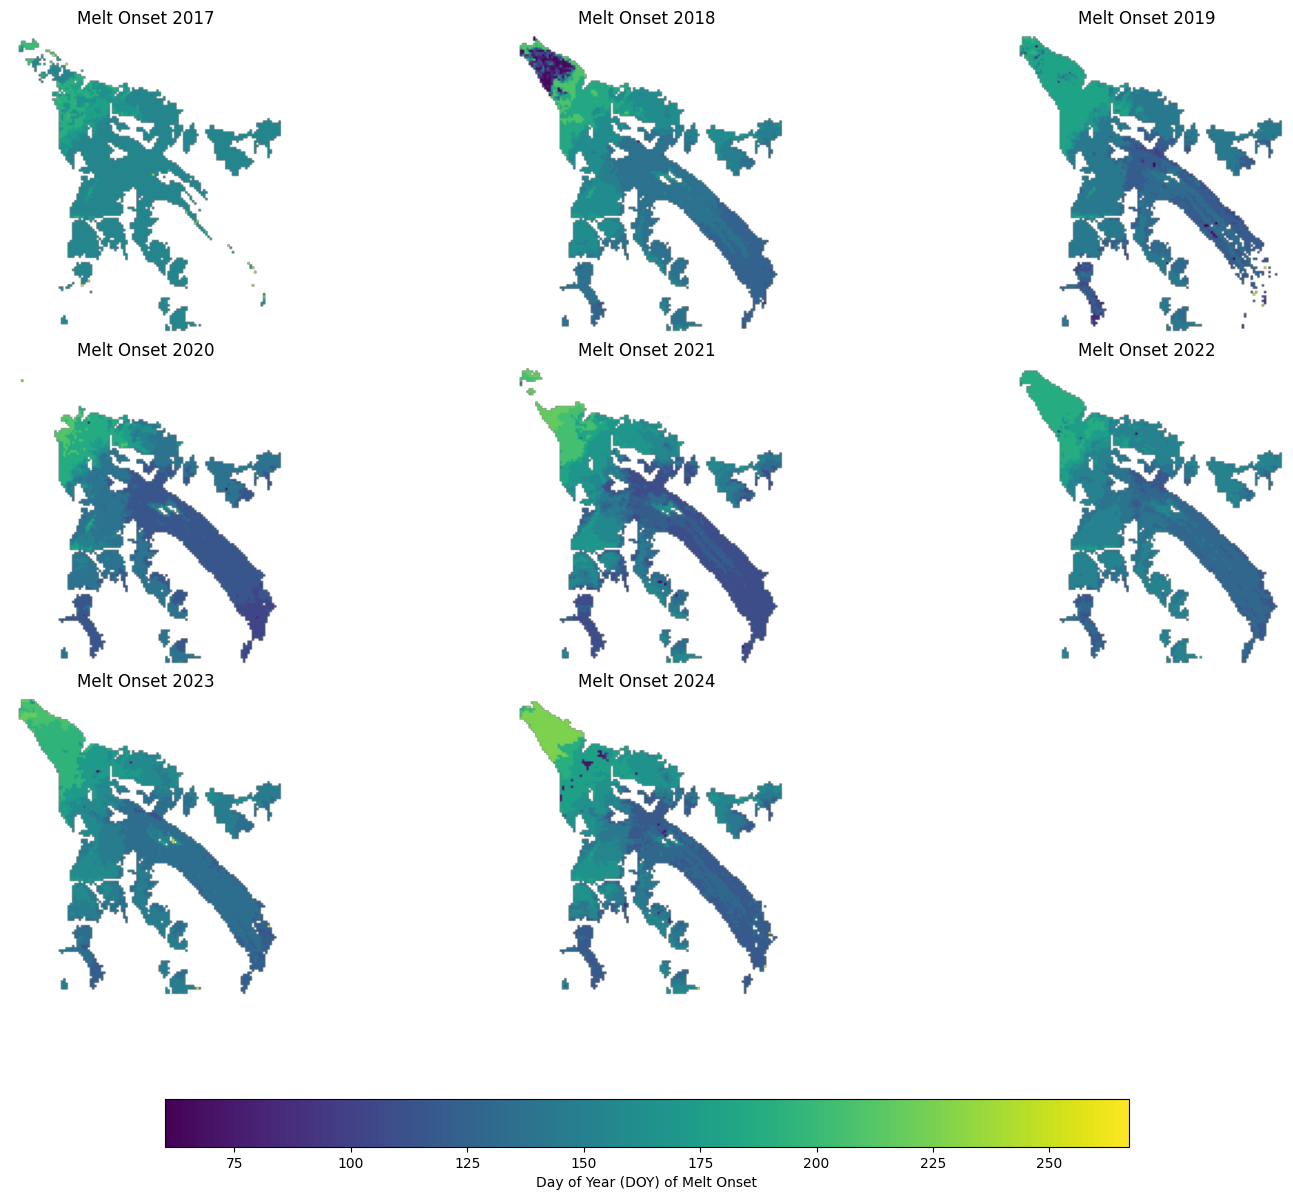

  0%|          | 0/1 [00:06<?, ?it/s]

(136, 123)
scenes: 226
failed glaciers: 0 [] 



In [11]:
#Process:

# RGI ID vs path-row dictionary
# makes it easier to access individual runs later on; code simply appends the path/row scenes for each glacier within a dictionary
rgi_ds_fn = 'rgino_ds_dict.json'
if os.path.exists(rgi_ds_fn):
    with open(rgi_ds_fn, 'r') as json_file:
        rgino_ds_dict = json.load(json_file)
else:
    rgino_ds_dict = {}


#fitting expected format:
data_no = 1
data_nos = [data_no]
outer_rng = tqdm(data_nos)
desc=DescStr()
scene_name = loaded_sar_data['1']['scene_name']
ds_fns = [loaded_sar_data['1']['cube_fn']]
pol_str = loaded_sar_data['1']['pol_str']
pathrow_str = "14-387"

scenes_no, failed_glacnos = process_datacube_to_melt_extent(i=data_no, outer_rng=outer_rng, desc=desc, ds_fns=ds_fns, 
        scene_name=scene_name, rgi_reg=rgi_reg, xres=xres, yres=yres, min_glac_area_km2=min_glac_area_km2, 
        db_threshold=db_threshold, db_threshold_sl=db_threshold_sl, zscore_threshold=zscore_threshold, winter_months=winter_months, 
        snowmelt_months=snowmelt_months, months2exclude_cp=months2exclude_cp, winter_std_threshold=winter_std_threshold, 
        bin_size=bin_size, area_bin_size=area_bin_size, allmelt_threshold=allmelt_threshold, allmelt_pixels=allmelt_pixels,
        pathrow_str=pathrow_str)
print('scenes:', scenes_no)
print('failed glaciers:', len(failed_glacnos), failed_glacnos, '\n')
#if area_ds_frac > self.min_area_frac and area_sar_frac > self.min_area_frac:

Reorganize csvs

In [12]:
# run this code to reorganize csv files into folders
import shutil

# get all files matching the pattern "csv01.XXXXX*"
main_directory = os.getcwd()
pattern = f"*{str(rgi_reg).zfill(2)}.[0-9]*.csv"
csv_files = glob.glob(os.path.join(csv_fp, pattern))
print(csv_fp)
print(csv_files)
# Process each file
for csv_file in csv_files:
    print(str(csv_file))
    csv_fn = os.path.basename(csv_file)
    glacier_name = csv_fn[0:8] # extract glacier name (first 8 characters: "01.XXXXX")

    glac_folder = os.path.join(csv_fp, glacier_name) # create the target directory if it doesn't exist
    os.makedirs(glac_folder, exist_ok=True)

    shutil.move(csv_file, os.path.join(glac_folder, csv_fn)) # move the file to its corresponding glacier folder

c:\Users\jaden\Downloads\Research\csv_comp\csv\
['c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05761_db_bin_mean_14-387.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05761_db_bin_mean_14-387_eabin.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05761_hypsometry_14-387.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05761_hypsometry_14-387_eabin.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05761_melt_extent_elev_percentile_14-387.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05761_melt_extent_elev_percentile_14-387_eabin.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05761_snowline_elev_percentile_14-387.csv', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\csv\\01.05761_snowline_elev_percentile_14-387_eabin.csv']
c:\Users\jaden\Downloads\Research\csv_comp\csv\01.05761_db_bin_mean_14-387.csv
c:\Users\jaden\Downloads\Research\csv_comp\csv\01.05761_db_bin_mean_14-387_eabin